# **Used Vehicle Price Data - ETL**

In [1]:
# Import dependencies
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

### *Import Vehicles Dataset from AWS S3 Bucket*

CSV hosted on S3 is 1.5GB. It may be too RAM intensive and not load. If it doesn't, try url (INSERT URL) for condensed sample csv to run through ETL notebook below.

In [2]:
# Import csv from S3 url
url = requests.get('https://vehicledatabootcamp.s3.amazonaws.com/vehicles.csv').content
vehicles_data = pd.read_csv(io.StringIO(url.decode('utf-8')))

### *Overview of Raw Dataset*

In [3]:
# View no. of unique values for each variable
vehicles_data.nunique(axis=0)

id              539759
url             539759
region             403
region_url         413
price            18386
year               113
manufacturer        43
model            36948
condition            6
cylinders            8
fuel                 5
odometer        122400
title_status         6
transmission         3
vin             181677
drive                3
size                 4
type                13
paint_color         12
image_url       364282
description     454053
county               0
state               51
lat              54587
long             54552
dtype: int64

In [4]:
# Confirm that 51st state was Washington DC
vehicles_data.state.unique() 

array(['nc', 'ne', 'co', 'ny', 'nj', 'va', 'tn', 'il', 'ia', 'mn', 'fl',
       'ma', 'tx', 'ca', 'or', 'ar', 'wa', 'ct', 'mi', 'sc', 'ks', 'nd',
       'wi', 'mt', 'pa', 'oh', 'wv', 'ms', 'nm', 'sd', 'ky', 'mo', 'la',
       'dc', 'al', 'nv', 'ri', 'ut', 'wy', 'vt', 'me', 'az', 'de', 'ak',
       'ok', 'ga', 'in', 'id', 'md', 'nh', 'hi'], dtype=object)

In [5]:
# See overview of raw data
vehicles_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,id,price,year,odometer,county,lat,long
count,539759.000000,539759.000000,538772.000000,440783.000000,0.000000,530785.000000,530785.000000
mean,7087608553.749804,195421.387573,2009.830982,100800.803259,nan,38.432128,-94.040501
std,5234175.784002,22082524.011569,9.161334,176705.802933,nan,5.916936,17.626658
min,7065764796.000000,0.000000,0.000000,0.000000,nan,-84.911400,-176.810000
25%,7084240305.500000,4400.000000,2007.000000,47038.500000,nan,34.197100,-106.782000
50%,7088972959.000000,9500.000000,2012.000000,93300.000000,nan,39.077600,-88.100900
75%,7092094043.000000,17926.000000,2015.000000,137755.000000,nan,42.449100,-81.219000
max,7093536715.000000,4294967295.000000,2021.000000,64809218.000000,nan,84.514800,161.016000


## *Removing NaN Values & Price Outliers*

#### Nan Values

There were too many NaN values in some columns so we decided to write a for loop that parsed through the dataset to remove any column where more than 40% of the values were NaN. This resulted in the 'condition', 'cylinders', 'vin', 'size', and 'county' columns being removed from the dataset.

In [6]:
# Remove columns with too many NaN values; only select variables that pass the threshold
NA_val = vehicles_data.isna().sum()
def na_filter(na, threshold = .4): 
    col_pass = []
    for i in na.keys():
        if na[i]/vehicles_data.shape[0]<threshold:
            col_pass.append(i)
    return col_pass
vehicles_data_cleaned = vehicles_data[na_filter(NA_val)]
vehicles_data_cleaned.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission', 'drive',
       'type', 'paint_color', 'image_url', 'description', 'state', 'lat',
       'long'],
      dtype='object')

In [ ]:
# #Replace remaining numerical NaN values with column means
# vehicles_data_cleaned.isnull().any()
# vehicles_data_cleaned = vehicles_data_cleaned.fillna(vehicles_data_cleaned.mean())

#### Price Outliers

The overview of the raw dataset above shows that the max price in the set is over $4B. As a result the spread of the standard deviation for the dataset is significantly and unrealistically skewed. We decided to set the range of prices to a more realistic spread using the interquartile range (IQR) method.

The IQR, also called the midspread, is a measure of statistical variability based on dividing a dataset into quartiles. It can be used to identify and remove outliers. Quartiles divide a rank-ordered dataset into four equal parts. The values that divide each part are called the first, second, and third quartiles; Q1, Q2, and Q3, respectively.

* Q1 is the middle value in the first half of the dataset.
* Q2 is the median value in the dataset.
* Q3 is the middle value in the second half of the dataset.

The theory of the IQR range rule is as follows:

> **1. Calculate IQR:** Q3 — Q1

> **2. Find the minimum number of the range:** Q1 — (1.5 * IQR)

> **3. Find the maximum number of the range:** Q3 + (1.5 * IQR)

> **4. Remove any values that lie outside of this range**

In [7]:
# Remove price outliers
vehicles_data_cleaned = vehicles_data_cleaned[vehicles_data_cleaned['price'].between(1000, 250000)]

# Define quartiles and calculate IQR
Q1 = vehicles_data_cleaned['price'].quantile(0.25)
Q3 = vehicles_data_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1

# Filter out values between Q1 - 1.5 * IQR and Q3 + 1.5 * IQR
vehicles_data_cleaned = vehicles_data_cleaned.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')

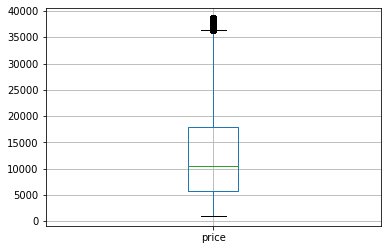

In [9]:
# Show distrubition of price once outliers are removed
vehicles_data_cleaned.boxplot('price')

### *Making Judgement Calls: Cut-offs for Year, Odometer / Choosing Columns to Drop Altogether*

#### Year

The overview of the data shows 2021 cars listed. Since any 2021 car would be a new car and the scope of our project is used cars, we removed all 2021 cars from the dataset. 

Additionally, we removed any car that was built before 1956 from the dataset. We chose 1956 as the cutoff because that's the year construction began on the National Interstate Highway System. After World War II, an increasing number of people began to flee major cities for the suburbs. The interstate highways were built to accommate the increasing number of cars on the road as more people bought cars to commute into the cities for work and travel between the suburbs.

Prior to that, owning a car was considered more of a luxury than a "must-have" item, so there were far fewer cars built before 1956. As a result, any car built pre-1956 still on the market today would command a much higher than average price, which would skew the dataset. So we decided to remove them.

In [12]:
# Removed cars older than 1956 and newer than 2020
vehicles_data_cleaned = vehicles_data_cleaned[vehicles_data_cleaned['year'].between(1956, 2020)]

#### Odometer

The max odometer mileage is listed as 64M+, which is obviously not correct, so we removed that from the dataset as well. To determine a reasonable ceiling for odometer mileage, we took the difference between 75th-percentile and the 25-percentile values and added that difference with a multiplier of 1.5 to the 75th-percentile value.

In [13]:
# Removed odomoter outliers = 137755 + 1.5 * (137755-47038.5)
vehicles_data_cleaned = vehicles_data_cleaned[vehicles_data_cleaned['odometer'].between(0, 273829.75)]

#### Dropping Columns

*We chose to drop certain columns from dataset based partially on intuition and partially on trial and error.* 

* **url, id, region_url, image_url:** These are not relevant to the analysis being conducted.

* **description:** This could be used with natural language processing, but that's beyond the scope of this project so it was disregarded.

* **region, state:** These two present the same information that latitude and longitude does more precisely.

* **model:** There were far too many distinct values to convert them to dummy variables. Additionally, we couldn’t use label encoding because the values are not ordered.

* **paint_color:** This was removed after conducting feature importance (*see machine learning notebook*). Since feature importance indicated that paint_color had little importance in determining price, we removed it and the accuracy of the model improved.

In [15]:
# Remove irrelevant columns
vehicles_final = vehicles_data_cleaned.copy().drop(['id', 'url', 'region_url', 'image_url', 
                                                     'description', 'model', 'paint_color', 
                                                     'state', 'region'], axis=1)

### *Overview of Final Dataset / Exporting as CSV*

In [16]:
# View final dataset
vehicles_final

,price,year,manufacturer,fuel,odometer,title_status,transmission,drive,type,lat,long
0,10299,2012.0,acura,gas,90186.0,clean,automatic,NaN,other,35.7636,-78.7443
2,9500,2011.0,jaguar,gas,85000.0,clean,automatic,NaN,NaN,36.1032,-79.8794
3,3995,2004.0,honda,gas,212526.0,clean,automatic,fwd,SUV,35.7636,-78.7443
5,12995,2015.0,kia,gas,85127.0,clean,automatic,4wd,wagon,35.7636,-78.7443
6,10995,2014.0,chevrolet,gas,112383.0,clean,automatic,fwd,SUV,35.7636,-78.7443
...,...,...,...,...,...,...,...,...,...,...,...
539753,12955,2015.0,mazda,gas,74508.0,clean,automatic,fwd,wagon,35.7636,-78.7443
539755,13995,2016.0,nissan,gas,97545.0,clean,automatic,4wd,pickup,35.7636,-78.7443
539756,10995,2010.0,bmw,gas,80328.0,clean,automatic,NaN,coupe,35.7636,-78.7443
539757,6495,2015.0,dodge,other,83521.0,clean,manual,fwd,sedan,35.7636,-78.7443


In [17]:
# See overview of data once numerical NaN values, outliers, and columns are removed
vehicles_final.describe()#.apply(lambda s: s.apply(lambda x: format(x, 'f')))

,price,year,odometer,lat,long
count,377969.000000,377969.000000,377969.000000,374741.000000,374741.000000
mean,13477.334244,2010.530655,100015.571552,38.650439,-93.791969
std,8681.048820,6.627536,57752.427878,5.761889,17.632650
min,1000.000000,1956.000000,0.000000,-84.911400,-170.288000
25%,6295.000000,2007.000000,52237.000000,34.601900,-106.617000
50%,11900.000000,2012.000000,97612.000000,39.322500,-87.705200
75%,18955.000000,2015.000000,140000.000000,42.496700,-81.018800
max,38629.000000,2020.000000,273795.000000,84.514800,161.016000


In [18]:
# Export to csv file
vehicles_final.to_csv('data/vehicles_cleaned.csv')